In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [5]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [6]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [7]:
tensor_data = FloatTensor(data.values[:1440],).view(1,1,-1)
tensor_data

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]]])

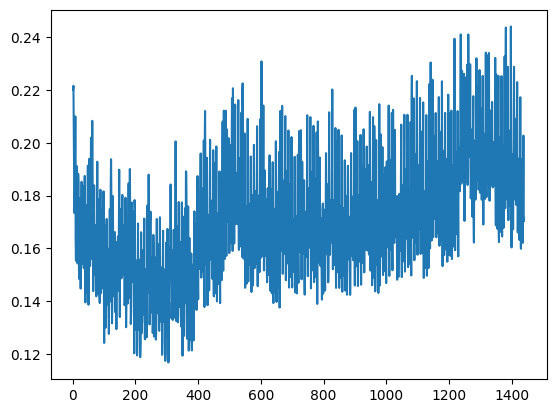

In [11]:
plt.plot(np.arange(1,1441),tensor_data[0,0,:]) 

Kernel의 크기가 3

In [7]:
decomp = series_decomp(3)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[-0.00047201  0.00577334  0.00153068 ...  0.01767999 -0.01126666
  0.00043733]
[0.22064    0.21581067 0.20414932 ... 0.18505602 0.18151467 0.17112267]


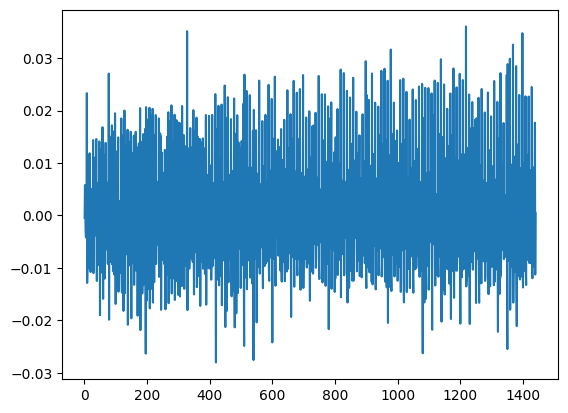

In [8]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 5

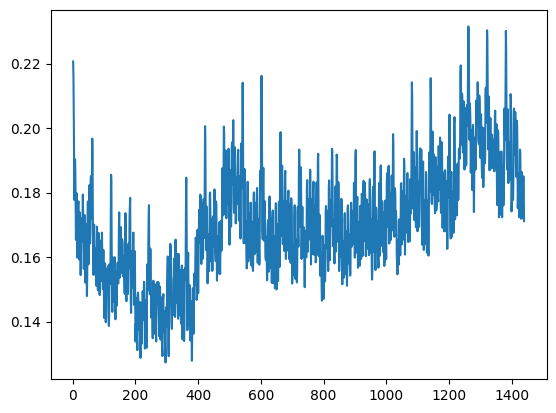

In [9]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 5

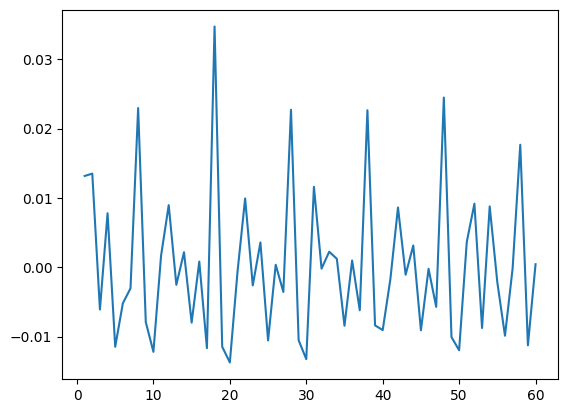

In [11]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

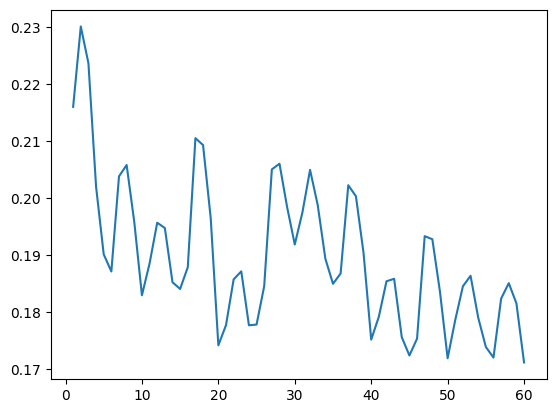

In [12]:
plt.plot(np.arange(1,61),trend_data[-60:])

###########################KernelSize=7######################################

In [17]:
decomp = series_decomp(25)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[ 0.01708224  0.02055171  0.00728004 ...  0.02550879 -0.00683841
 -0.00488512]
[0.20308575 0.2010323  0.19839996 ... 0.17722721 0.17708641 0.17644513]


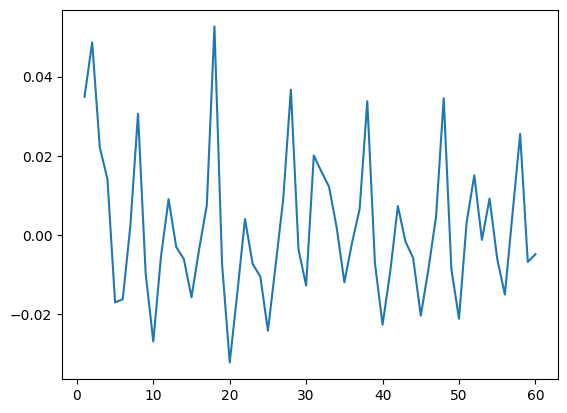

In [18]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

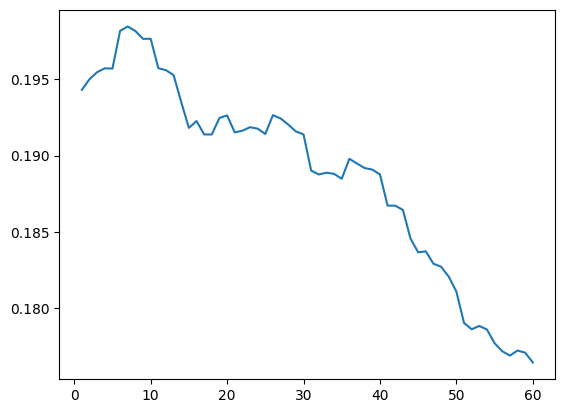

In [19]:
plt.plot(np.arange(1,61),trend_data[-60:])

###########################KernelSize=5######################################

In [13]:
decomp = series_decomp(5)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()# trend data가 곧 moving avg data
print(seasonal_data)
print(trend_data)

[ 0.00261441  0.01102722  0.00446399 ...  0.02496959 -0.00940961
 -0.00597279]
[0.21755359 0.21055679 0.20121601 ... 0.17776641 0.17965761 0.17753279]


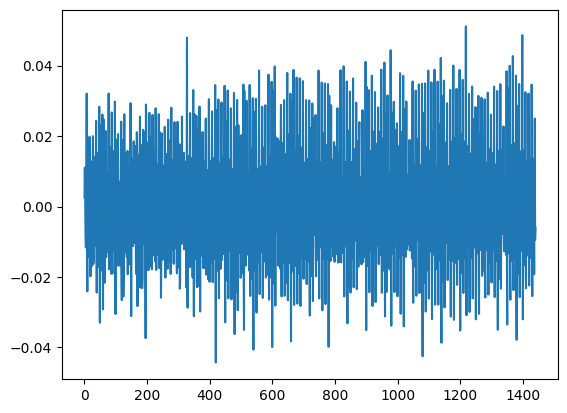

In [14]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 5

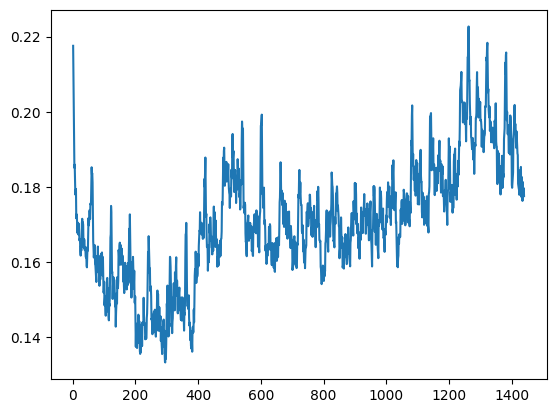

In [15]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 65

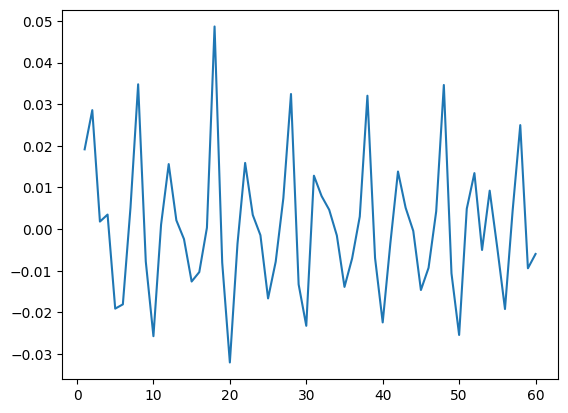

In [16]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

###########################KernelSize=65######################################

In [17]:
decomp = series_decomp(65)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[ 0.0227569   0.02511828  0.01025389 ...  0.02306986 -0.00921309
 -0.00744092]
[0.19741109 0.19646573 0.1954261  ... 0.17966615 0.17946109 0.17900093]


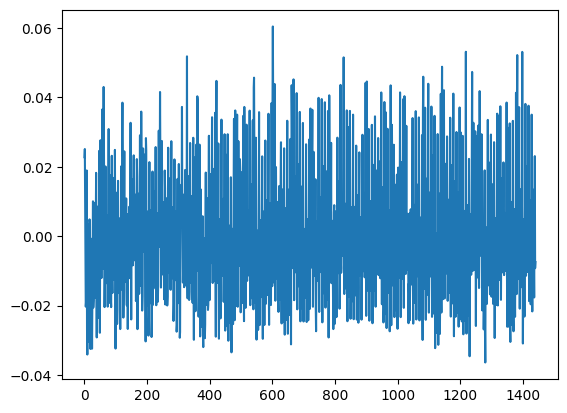

In [18]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 65

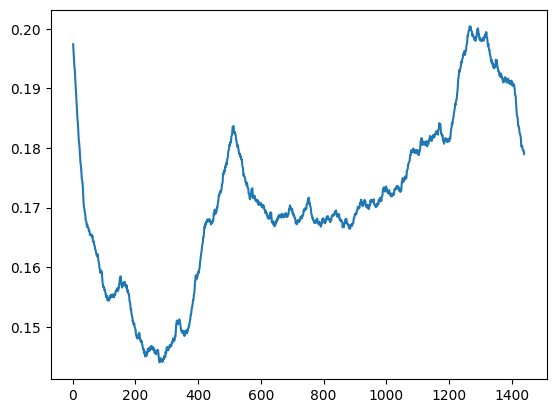

In [19]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 65

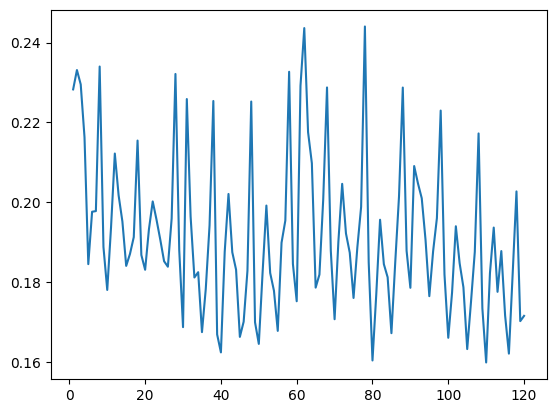

In [21]:
plt.plot(np.arange(1,121),tensor_data.view(-1).numpy()[-120:]) # 원데이터 

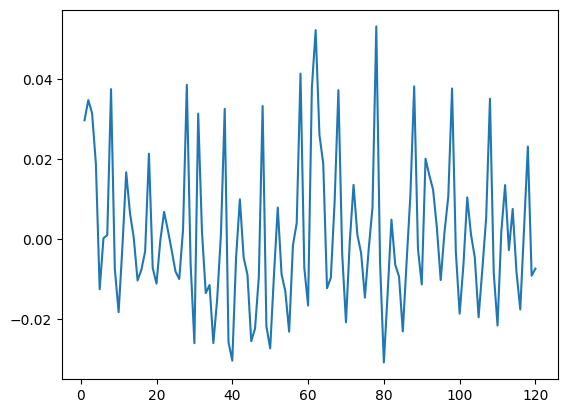

In [24]:
plt.plot(np.arange(1,121),seasonal_data[-120:])

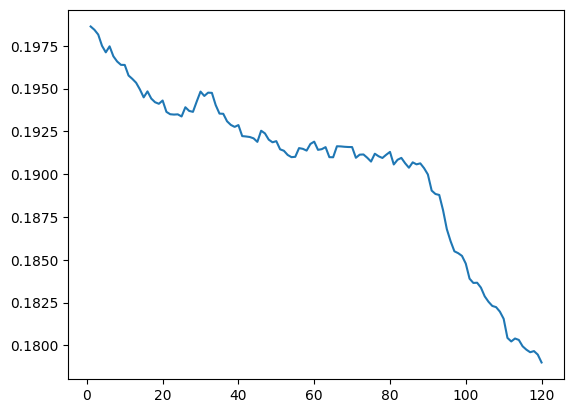

In [25]:
plt.plot(np.arange(1,121),trend_data[-120:])

잘 정제된 seasonality와 덜 정제된 seasonality를 사용해서 좋은 결과를 도출하기를 원한다

###########################KernelSize=1439######################################

In [26]:
decomp = series_decomp(1439)
seasonal,trend = decomp(tensor_data)
seasonal_data,trend_data = seasonal.view(-1).numpy(),trend.view(-1).numpy()
print(seasonal_data)
print(trend_data)

[ 0.02910793  0.03054877  0.01465565 ...  0.02709746 -0.00539975
 -0.00410482]
[0.19106007 0.19103524 0.19102435 ... 0.17563854 0.17564775 0.17566483]


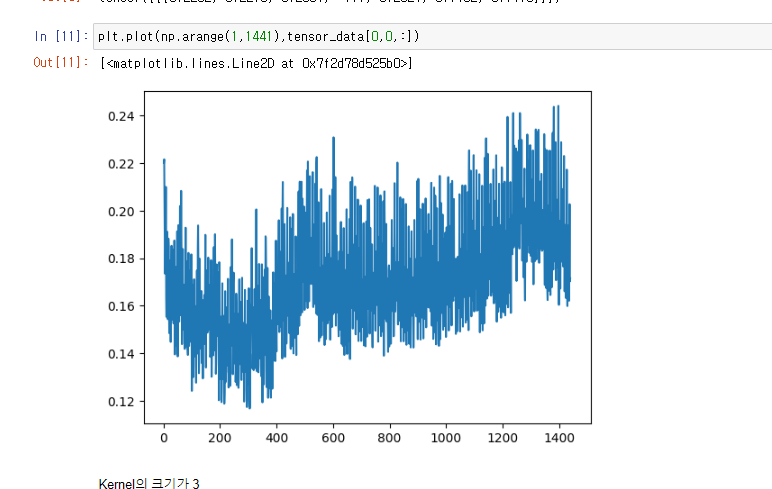

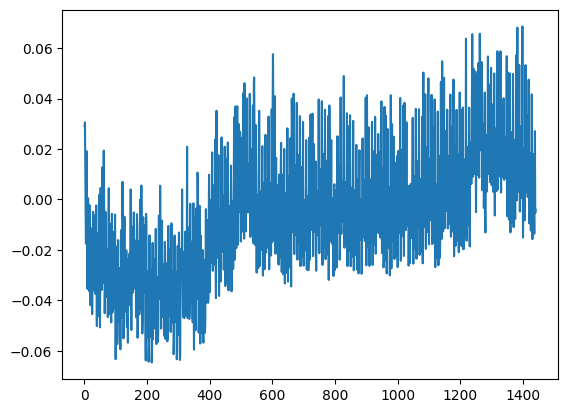

In [27]:
plt.plot(np.arange(1,1441),seasonal_data) #plot 데이터 kernel size = 5

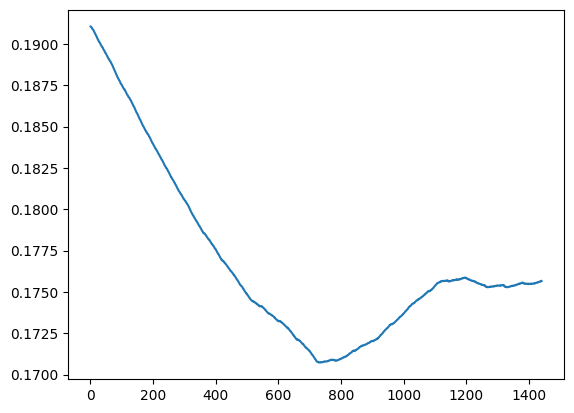

In [28]:
plt.plot(np.arange(1,1441),trend_data) #plot 데이터 kernel size = 5

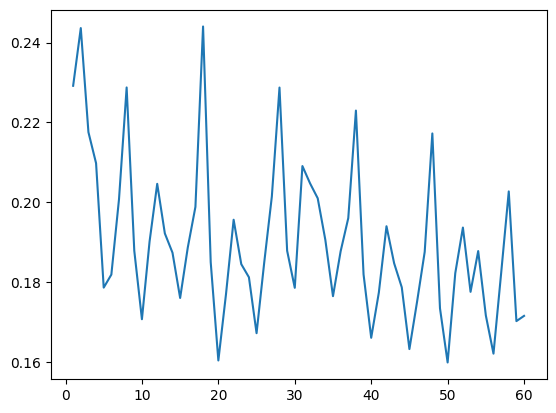

In [29]:
plt.plot(np.arange(1,61),tensor_data.view(-1).numpy()[-60:]) # 원데이터 

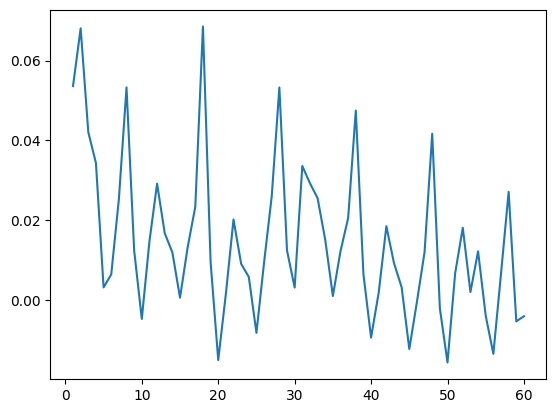

In [30]:
plt.plot(np.arange(1,61),seasonal_data[-60:])

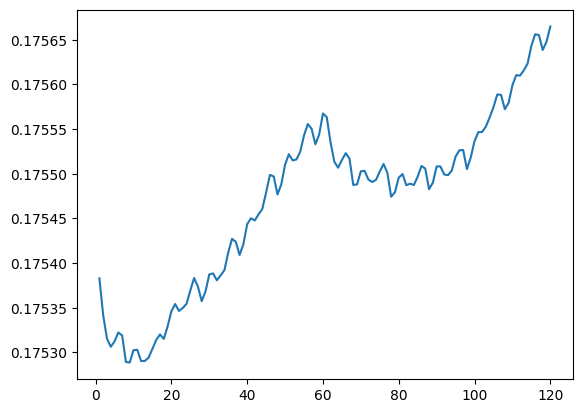

In [31]:
plt.plot(np.arange(1,121),trend_data[-120:])

kernel size를 극단적으로 키우면 padding 되는 값이 그만큼 많아지니깐 moving avg의 변동폭이 작아지게 되고(거의 직선이 되고 따라서 seasonality의 모양이 원데이터를 따라가게 된다